In [1]:
!pip install unsloth vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.4/414.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 80.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 100.5 MB/s eta 0:00:0000:0100:01
  

In [2]:
import os
import re
import difflib
import shutil
import pandas as pd
from peft import PeftModel
from vllm import SamplingParams
from transformers import TextStreamer
from datasets import load_dataset, Dataset
from unsloth import FastLanguageModel, is_bfloat16_supported
from unsloth.chat_templates import CHAT_TEMPLATES, get_chat_template
from trl import SFTTrainer, SFTConfig, GRPOConfig, GRPOTrainer

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

2025-08-20 13:36:20.070463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755696980.294349      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755696980.361086      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_36/1237782436.py:10: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 08-20 13:36:42 [__init__.py:241] Automatically detected platform cuda.
ERROR 08-20 13:36:44 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
instruction_data = load_dataset("unsloth/OpenMathReasoning-mini")

instruction_data

README.md:   0%|          | 0.00/603 [00:00<?, ?B/s]

data/cot-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

Generating cot split:   0%|          | 0/19252 [00:00<?, ? examples/s]

DatasetDict({
    cot: Dataset({
        features: ['expected_answer', 'problem_type', 'problem_source', 'generation_model', 'pass_rate_72b_tir', 'problem', 'generated_solution', 'inference_mode'],
        num_rows: 19252
    })
})

In [4]:
instruct_df = instruction_data["cot"].to_pandas()

instruct_df = instruct_df[instruct_df["problem"].apply(lambda x: len(x) < 300)][["problem", "generated_solution", "expected_answer"]]

print(instruct_df.shape)

instruct_df.head()

(18356, 3)


,problem,generated_solution,expected_answer
0,Given $\sqrt{x^2+165}-\sqrt{x^2-52}=7$ and $x$...,"<think>\nOkay, let's see. I need to solve the ...",14
1,Let \( \sum a_n \) be a convergent series with...,"<think>\nOkay, so I have this problem here whe...",convergent
2,"For \( a > 0 \), find the value of \( \int_0^{...","<think>\nOkay, so I need to solve the integral...",\(\frac{\pi \ln a}{2a}\)
3,Calculate $\lim_{n\to\infty}\sqrt[n]{n!}$.,"<think>\nOkay, so I need to find the limit as ...",\(+\infty\)
4,Find all positive integers \( n \) such that \...,"<think>\nOkay, so I need to find all positive ...",\( n = 1 \)


In [5]:
instruct_df_filtered = instruct_df[pd.to_numeric(instruct_df["expected_answer"], errors="coerce").notnull()].reset_index(drop=True)

print(instruct_df_filtered.shape)

instruct_df_filtered.head()

(7044, 3)


,problem,generated_solution,expected_answer
0,Given $\sqrt{x^2+165}-\sqrt{x^2-52}=7$ and $x$...,"<think>\nOkay, let's see. I need to solve the ...",14
1,Find the value of the parameter $a$ for which ...,"<think>\nOkay, so I need to find the value of ...",-2
2,What is the sum of all real numbers $x$ for wh...,"<think>\nOkay, so I need to solve the equation...",18
3,Evaluate the sum \(\sum_{n=1}^\infty \frac{\ph...,"<think>\nOkay, so I need to evaluate the infin...",2
4,What is the largest positive integer that divi...,"<think>\nAlright, so I need to find the larges...",30


In [6]:
instruct_df_filtered["problem"].apply(lambda x: len(x)).max()

299

In [7]:
instruct_df_filtered_dataset = Dataset.from_pandas(instruct_df_filtered)

instruct_df_filtered_dataset

Dataset({
    features: ['problem', 'generated_solution', 'expected_answer'],
    num_rows: 7044
})

In [8]:
fast_model, fast_tokenizer = FastLanguageModel.from_pretrained(
                                                                model_name="unsloth/Qwen3-4B-Base",
                                                                max_seq_length=2048,
                                                                dtype=None,
                                                                load_in_4bit=False,
                                                                fast_inference=True,
                                                                gpu_memory_utilization=0.5,
                                                                float8_kv_cache=False,
                                                                random_state=2025
                                                            )

Unsloth: Patching vLLM v1 graph capture
Unsloth: Patching vLLM v0 graph capture
Unsloth: vLLM does not work on older GPUs - will switch to Unsloth inference!
==((====))==  Unsloth 2025.8.8: Fast Qwen3 patching. Transformers: 4.55.2. vLLM: 0.10.1.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 6.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [9]:
list(CHAT_TEMPLATES)

['unsloth',
 'zephyr',
 'chatml',
 'mistral',
 'llama',
 'vicuna',
 'vicuna_old',
 'vicuna old',
 'alpaca',
 'gemma',
 'gemma_chatml',
 'gemma2',
 'gemma2_chatml',
 'llama-3',
 'llama3',
 'phi-3',
 'phi-35',
 'phi-3.5',
 'llama-3.1',
 'llama-31',
 'llama-3.2',
 'llama-3.3',
 'llama-32',
 'llama-33',
 'qwen-2.5',
 'qwen-25',
 'qwen25',
 'qwen2.5',
 'phi-4',
 'gemma-3',
 'gemma3',
 'qwen-3',
 'qwen3',
 'gemma-3n',
 'gemma3n',
 'gpt-oss',
 'gptoss',
 'qwen3-instruct',
 'qwen3-thinking']

In [10]:
fast_tokenizer_template = get_chat_template(tokenizer=fast_tokenizer, chat_template='qwen-3')

In [11]:
lora_peft_model = FastLanguageModel.get_peft_model(
    model=fast_model, 
    r=32,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'],
    lora_alpha=32*2,
    lora_dropout=0.0,
    bias='none',
    use_gradient_checkpointing='unsloth',
    random_state=2025,
    max_seq_length=2048
)

Unsloth 2025.8.8 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [12]:
fast_tokenizer_template.chat_template = """{%- for message in messages %}
    {%- if message['role'] == 'system' -%}
        {{ message['content'] + eos_token }}
    {%- elif message['role'] == 'user' -%}
        {{ message['content'] }}
    {%- elif message['role'] == 'assistant' -%}
        {{ message['content'] + eos_token }}
    {%- endif -%}
{%- endfor %}
{%- if add_generation_prompt -%} 
    {{'<workings>'}}
{%- endif -%}
"""
print(fast_tokenizer_template.chat_template)

{%- for message in messages %}
    {%- if message['role'] == 'system' -%}
        {{ message['content'] + eos_token }}
    {%- elif message['role'] == 'user' -%}
        {{ message['content'] }}
    {%- elif message['role'] == 'assistant' -%}
        {{ message['content'] + eos_token }}
    {%- endif -%}
{%- endfor %}
{%- if add_generation_prompt -%} 
    {{'<workings>'}}
{%- endif -%}



In [13]:
fast_tokenizer_template.eos_token, fast_tokenizer_template.pad_token

('<|endoftext|>', '<|vision_pad|>')

In [14]:
system_instruction = \
"""You are given a problem. 
Place your reasoning and working between: 
<workings>[summary of solution]</workings>
Then, provide your final answer between:
<answer>[integer]</answer>"""

def PrepDataForApplyTemplate(data):
    global system_instruction
    data_per_step = []
    message_templates = []
    cot = []
    for problem, generated_solution, expected_answer in zip(data["problem"], data["generated_solution"], data["expected_answer"]):
        step_by_step_solution = generated_solution.replace("<think>", "").replace("</think>", "").strip()
        prompt_template = "<workings>"+step_by_step_solution+"</workings>"+"<answer>"+expected_answer+"</answer>"
        message_template = [
                            {"role":"system", "content":system_instruction},
                            {"role":"user", "content":problem},
                            {"role":"assistant", "content":prompt_template}
                           ]

        message_templates.append(message_template)
        data_per_step.append(fast_tokenizer_template.apply_chat_template(message_template, tokenize=False, add_generation_prompt=False))
        cot.append(step_by_step_solution)
        
    return {"instruction_template":data_per_step, "messages":message_templates, "step_by_step_solution":cot}

In [15]:
prep_instruct_data = instruct_df_filtered_dataset.map(PrepDataForApplyTemplate, batched=True).to_pandas()

prep_instruct_data["cot_length"] = prep_instruct_data["step_by_step_solution"].apply(lambda x: len(x))

prep_instruct_data = prep_instruct_data[prep_instruct_data["cot_length"] < 2300]

print(prep_instruct_data.shape)

prep_instruct_data = Dataset.from_pandas(prep_instruct_data).train_test_split(test_size=.1, seed=2025)

train_instruct_data = prep_instruct_data["train"]

test_instruct_data = prep_instruct_data["test"]

Map:   0%|          | 0/7044 [00:00<?, ? examples/s]

(14, 7)


In [16]:
train_instruct_data

Dataset({
    features: ['problem', 'generated_solution', 'expected_answer', 'instruction_template', 'messages', 'step_by_step_solution', 'cot_length', '__index_level_0__'],
    num_rows: 12
})

In [17]:
test_instruct_data

Dataset({
    features: ['problem', 'generated_solution', 'expected_answer', 'instruction_template', 'messages', 'step_by_step_solution', 'cot_length', '__index_level_0__'],
    num_rows: 2
})

In [18]:
train_instruct_data[1]

{'problem': 'If $n! = 2,432,902,008,176,640,000,$ find the value of $n$ without using any electronic device.',
 'generated_solution': "<think>\nOkay, so I need to find the value of n where n! equals 2,432,902,008,176,640,000. Hmm, factorials can get really big very quickly, so I guess n isn't going to be a very small number. Let me think about the factorials of numbers I know.\n\nStarting from 1! up:\n\n1! = 1\n\n2! = 2\n\n3! = 6\n\n4! = 24\n\n5! = 120\n\n6! = 720\n\n7! = 5040\n\n8! = 40320\n\n9! = 362880\n\n10! = 3,628,800\n\n11! = 39,916,800\n\n12! = 479,001,600\n\n13! = 6,227,020,800\n\n14! = 87,178,291,200\n\n15! = 1,307,674,368,000\n\n16! = 20,922,789,888,000\n\n17! = 355,687,428,096,000\n\n18! = 6,402,373,705,728,000\n\n19! = 121,645,100,408,832,000\n\n20! = 2,432,902,008,176,640,000\n\nWait a second, 20! is exactly the number given in the problem. Let me double-check that. So 19! is 121 quintillion something, and multiplying that by 20 should give 2,432 quintillion... yes, becau

In [19]:
# sft_vllm_sampling_params = SamplingParams(
#     min_p = 0.1,                  
#     top_p = 0.8, 
#     temperature=1,
#     top_k = 20,                  
#     seed = 2025,                    
#     stop = [fast_tokenizer_template.eos_token], 
#     include_stop_str_in_output = True,
# )

sft_config = SFTConfig(
    output_dir="instruct_model",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    # vllm_sampling_params=sft_vllm_sampling_params,
    learning_rate=3e-04,
    weight_decay=0.01,
    warmup_steps = 5,
    num_train_epochs=5,   
    optim='adamw_8bit',
    logging_strategy="epoch",
    eval_strategy="epoch",
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type='linear',
    max_length=2048,
    bf16=is_bfloat16_supported(),
    fp16=not is_bfloat16_supported(),
    gradient_checkpointing=True,
    remove_unused_columns=True,
    eos_token=fast_tokenizer_template.eos_token,
    pad_token=fast_tokenizer_template.pad_token,
    dataset_text_field='instruction_template',
    report_to="none"
)

# Prepare Model for training
FastLanguageModel.for_training(model=lora_peft_model)

sft_trainer = SFTTrainer(
    model=lora_peft_model,
    args=sft_config,
    train_dataset=train_instruct_data,
    eval_dataset=test_instruct_data,
    processing_class=fast_tokenizer_template,
)

Unsloth: Tokenizing ["instruction_template"] (num_proc=2):   0%|          | 0/12 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["instruction_template"] (num_proc=2):   0%|          | 0/2 [00:00<?, ? examples/s]

In [20]:
sft_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12 | Num Epochs = 5 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Epoch,Training Loss,Validation Loss
1,0.555000,0.355274
2,0.238600,0.291650
3,0.090500,0.346782
4,0.035500,0.380914
5,0.015200,0.422638


Unsloth: Will smartly offload gradients to save VRAM!


TrainOutput(global_step=60, training_loss=0.1869693011045456, metrics={'train_runtime': 245.5313, 'train_samples_per_second': 0.244, 'train_steps_per_second': 0.244, 'total_flos': 1097441104527360.0, 'train_loss': 0.1869693011045456})

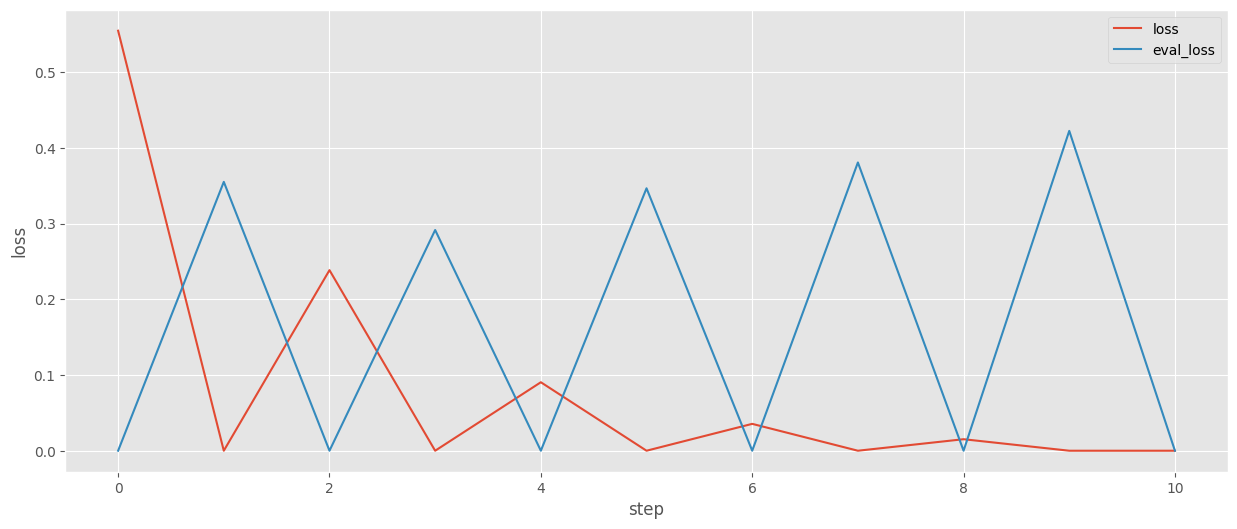

In [21]:
pd.DataFrame(sft_trainer.state.log_history)[["loss", "eval_loss"]].fillna(0).plot(kind="line",
                                                                                  xlabel="step",
                                                                                  ylabel="loss",
                                                                                  figsize=(15, 6))
                                                                      
plt.show()

In [22]:
def InferenceInstructModel(query, model, tokenizer):
    FastLanguageModel.for_inference(model)
    input_template = tokenizer.apply_chat_template(
                                                    [
                                                    {"role":"system", "content":system_instruction},
                                                    {"role":"user", "content":query}
                                                    ], 
                                                   tokenize=False,
                                                   add_generation_prompt=True
                                                  )
    _ = model.generate(
        **tokenizer(input_template, return_tensors="pt").to("cuda:0"),
        temperature=0,
        max_new_tokens = 2048,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        streamer = TextStreamer(tokenizer, skip_prompt=False)
    )

In [23]:
query = 'Alan has 3 more dollars than Bill. Bill has 5 more dollars than Charles and Deb combined. Deb has 7 dollars more than Charlie, who has 5 dollars. How much money does Alan have?'

InferenceInstructModel(query,
                       sft_trainer.model, 
                       sft_trainer.processing_class)

You are given a problem. 
Place your reasoning and working between: 
<workings>[summary of solution]</workings>
Then, provide your final answer between:
<answer>[integer]</answer><|endoftext|>Alan has 3 more dollars than Bill. Bill has 5 more dollars than Charles and Deb combined. Deb has 7 dollars more than Charlie, who has 5 dollars. How much money does Alan have?<workings>Okay, let's see. I need to figure out how much money Alan has. The problem says Alan has 3 more dollars than Bill. So, if I can find out how much Bill has, I just add 3 to that to get Alan's amount. 

Now, Bill has 5 more dollars than Charles and Deb combined. Hmm, so Bill's money is Charles and Deb's money added together plus 5. But wait, the problem mentions Deb has 7 dollars more than Charlie, who has 5 dollars. Let me check that part. Charlie has 5 dollars, and Deb has 7 more than that. So Deb's money would be 5 + 7, which is 12 dollars. 

So Charles has 5 dollars, Deb has 12 dollars. Combined, that's 5 + 12 = 

In [24]:
query = 'What is the power of the expression $17\\sqrt{x^5}y^\\frac{7}{4} z^3$ with respect to $z$?'

InferenceInstructModel(query,
                       sft_trainer.model, 
                       sft_trainer.processing_class)

You are given a problem. 
Place your reasoning and working between: 
<workings>[summary of solution]</workings>
Then, provide your final answer between:
<answer>[integer]</answer><|endoftext|>What is the power of the expression $17\sqrt{x^5}y^\frac{7}{4} z^3$ with respect to $z$?<workings>Okay, let's see. The problem is asking for the power of the expression \(17\sqrt{x^5}y^{\frac{7}{4}}z^3\) with respect to \(z\). Hmm, power with respect to a variable. Right, that should mean the exponent on that variable in the expression. So in this case, the variable is \(z\), and its exponent is 3. Let me double-check. The expression is \(17\sqrt{x^5}y^{\frac{7}{4}}z^3\). The square root of \(x^5\) can be written as \(x^{5/2}\), but that's not part of the \(z\) term. The \(y\) term has a fractional exponent, but again, that's not \(z\). So the only term with \(z\) is \(z^3\). Therefore, the power with respect to \(z\) is 3. Yep, that makes sense. So the answer should be 3.
To determine the power o

In [25]:
# sft_trainer.model.save_pretrained_merged("instruction_model", sft_trainer.processing_class, save_method = "merged_16bit",)

In [26]:
# def download_folder(folder_path, zip_name="output"):
#     """Create a zip file and provide download link"""
#     zip_path = f'/kaggle/working/{zip_name}.zip'
    
#     # Create zip file
#     shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)
    
#     # Provide download link
#     print(f"Zip created: {zip_path}")

# download_folder('/kaggle/working/instruct_model/checkpoint-9/', 'instruct_model_file')

In [27]:
# def ClearOutput(directory="/kaggle/working/"):
#     for i in os.listdir(directory):
#         try:
#             shutil.rmtree(path=os.path.join(directory, i))
#         except:
#             os.remove(path=os.path.join(directory, i))

# ClearOutput()

In [28]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

2435

In [29]:
prep_instruct_data

DatasetDict({
    train: Dataset({
        features: ['problem', 'generated_solution', 'expected_answer', 'instruction_template', 'messages', 'step_by_step_solution', 'cot_length', '__index_level_0__'],
        num_rows: 12
    })
    test: Dataset({
        features: ['problem', 'generated_solution', 'expected_answer', 'instruction_template', 'messages', 'step_by_step_solution', 'cot_length', '__index_level_0__'],
        num_rows: 2
    })
})

In [30]:
grpo_data = instruct_df_filtered_dataset.map(PrepDataForApplyTemplate, batched=True).to_pandas()

grpo_data["cot_length"] = grpo_data["step_by_step_solution"].apply(lambda x: len(x))

grpo_data = grpo_data[grpo_data["cot_length"] < 2300]

print(grpo_data.shape)

grpo_data = Dataset.from_pandas(grpo_data).train_test_split(test_size=.2, seed=2025)

train_grpo_data = grpo_data["train"]

test_grpo_data = grpo_data["test"]

Map:   0%|          | 0/7044 [00:00<?, ? examples/s]

(14, 7)


In [31]:
grpo_data

DatasetDict({
    train: Dataset({
        features: ['problem', 'generated_solution', 'expected_answer', 'instruction_template', 'messages', 'step_by_step_solution', 'cot_length', '__index_level_0__'],
        num_rows: 11
    })
    test: Dataset({
        features: ['problem', 'generated_solution', 'expected_answer', 'instruction_template', 'messages', 'step_by_step_solution', 'cot_length', '__index_level_0__'],
        num_rows: 3
    })
})

In [32]:
prep_grpo_train_dataset = train_grpo_data.map(
                                     lambda x: {
                                            "prompt":[
                                                {"role":"system", "content":system_instruction},
                                                {"role":"user", "content":x["problem"]}
                                            ],
                                            "answer":x["expected_answer"]
                                        },
                                    remove_columns=train_grpo_data.column_names
                                    )


prep_grpo_test_dataset = test_grpo_data.map(
                                     lambda x: {
                                            "prompt":[
                                                {"role":"system", "content":system_instruction},
                                                {"role":"user", "content":x["problem"]}
                                            ],
                                            "answer":x["expected_answer"]
                                        },
                                    remove_columns=test_grpo_data.column_names
                                    )

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [33]:
prep_grpo_train_dataset

Dataset({
    features: ['prompt', 'answer'],
    num_rows: 11
})

In [34]:
prep_grpo_test_dataset

Dataset({
    features: ['prompt', 'answer'],
    num_rows: 3
})

In [35]:
prep_grpo_train_dataset[:]

{'prompt': [[{'content': 'You are given a problem. \nPlace your reasoning and working between: \n<workings>[summary of solution]</workings>\nThen, provide your final answer between:\n<answer>[integer]</answer>',
    'role': 'system'},
   {'content': 'If $n! = 2,432,902,008,176,640,000,$ find the value of $n$ without using any electronic device.',
    'role': 'user'}],
  [{'content': 'You are given a problem. \nPlace your reasoning and working between: \n<workings>[summary of solution]</workings>\nThen, provide your final answer between:\n<answer>[integer]</answer>',
    'role': 'system'},
   {'content': 'Compute the value of the expression $(x-a)(x-b)\\ldots (x-z)$.',
    'role': 'user'}],
  [{'content': 'You are given a problem. \nPlace your reasoning and working between: \n<workings>[summary of solution]</workings>\nThen, provide your final answer between:\n<answer>[integer]</answer>',
    'role': 'system'},
   {'content': 'Mary has taken four tests and has a test average of 94. Her 

In [36]:
model_output = \
"""
Okay, let me try to understand this problem. It's asking for the power of the expression \(17\sqrt{x^5}y^{\frac{7}{4}}z^3\) with respect to \(z\). Hmm, power with respect to a variable... That should mean the exponent on that variable in the term. So here, the term is \(z^3\), and the exponent on \(z\) is 3. Wait, is that all there is to it? Let me think again. The problem doesn't mention anything about differentiating or anything like that, just the power with respect to \(z\). So yeah, the power should just be the exponent on \(z\), which is 3. So the answer should be 3. Let me double-check. The term is \(z^3\), and the power on \(z\) is 3. Yes, that makes sense. So the final answer is 3.<answer>3</answer><|endoftext|>
"""

In [37]:
match_format = re.compile(
    r"<answer>(.*?)</answer><\|endoftext\|>",
    flags=re.DOTALL|re.MULTILINE
)

In [38]:
match_format.search(model_output.strip()).group(0)

'<answer>3</answer><|endoftext|>'

In [39]:
match_format_ = re.compile(
        r"<answer>(.*?)</answer><\|endoftext\|>",
        flags=re.DOTALL
    )

In [40]:
match_format_.search(model_output.strip()).group(0), match_format_.search(model_output.strip()).group(1)

('<answer>3</answer><|endoftext|>', '3')

In [41]:
difflib.SequenceMatcher(None, "13".lower().strip(), "14".lower().strip()).ratio()

0.5

In [42]:
def MatchTemplateExactly(completions, **kwargs):
    full_match_format = re.compile(
    r"</workings><answer>(.*?)</answer><\|endoftext\|>",
    flags=re.DOTALL|re.MULTILINE
)
    partial_match_format = re.compile(
        r"<answer>(.*?)</answer>",
        flags=re.DOTALL
    )
    scores = []
    for i in completions:
        content = i[0]["content"].strip()
        if full_match_format.search(content):
            scores.append(3)
        elif partial_match_format.search(content):
            scores.append(1)
        else:
            scores.append(0)
    return scores


def MatchFormatApproximately(completions, **kwargs):
    scores = []
    for i in completions:
        score = 0
        response = i[0]["content"]
        score += 1 if response.count("</workings>") == 1 else -1
        score += 1 if response.count("<answer>") == 1 else -1
        score += 1 if response.count("</answer>") == 1 else -0.5
        score += 1 if response.count("<|endoftext|>") == 1 else -1
        scores.append(score)
    return scores

PRINTED_TIMES = 0
PRINT_EVERY_STEPS = 5

def CheckAnswerAccuracyWithPrint(completions, answer, prompts, **kwargs):
    global PRINTED_TIMES
    scores = []
    match_format = re.compile(r"<answer>(.*?)</answer>", flags=re.DOTALL)        

    for completion, expected_answer, prompt in zip(completions, answer, prompts):
        response = completion[0]["content"]

        # Print for debugging
        if PRINTED_TIMES % PRINT_EVERY_STEPS == 0:
            print("*"*20)
            print("Prompt:\n", prompt[-1]["content"])
            print("Response:\n", response)
            print("Expected:\n", expected_answer)
            print("*"*20)
        PRINTED_TIMES += 1
        
        score = 0
        match = match_format.search(response)
        if match:
            extracted = match.group(1).strip()
            similarity = difflib.SequenceMatcher(None, extracted.lower(), expected_answer.replace("\\(", "").replace("\\)", "").lower()).ratio()
            if similarity == 1.0:
                score += 5
            elif similarity >= 0.5:
                score += 3
        scores.append(score)

    print("Score:",score)
    return scores  

In [43]:
vllm_sampling_params = SamplingParams(
    n=4,
    min_p = 0.1,                 
    top_p = 0.8, 
    temperature=1,
    top_k = 20,                     
    seed = 2025,                    
    stop = [sft_trainer.processing_class.eos_token], 
    include_stop_str_in_output = True,  
)

grpo_config = GRPOConfig(
    output_dir="thinking_model",
    learning_rate=3e-04,
    vllm_sampling_params=vllm_sampling_params,
    weight_decay=0.01,
    warmup_steps = 5,
    num_train_epochs=2,
    per_device_train_batch_size=1,
    # per_device_eval_batch_size=1,
    optim='adamw_8bit',
    logging_strategy="epoch",
    # eval_strategy="epoch",
    # metric_for_best_model="eval_loss",
    # save_total_limit=1,
    # save_strategy="epoch",
    # load_best_model_at_end=True,
    lr_scheduler_type='linear',
    max_completion_length=1024,
    bf16=is_bfloat16_supported(),
    fp16=not is_bfloat16_supported(),
    fp16_full_eval = True,
    num_generations=4,
    gradient_checkpointing=True,
    report_to="none"
)
                       
grpo_trainer = GRPOTrainer(
    model=sft_trainer.model,
    reward_funcs=[MatchTemplateExactly, 
                  MatchFormatApproximately, 
                  CheckAnswerAccuracyWithPrint],
    args=grpo_config,
    train_dataset=prep_grpo_train_dataset,
    # eval_dataset=prep_grpo_test_dataset,
    processing_class=sft_trainer.processing_class,
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


In [44]:
grpo_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11 | Num Epochs = 2 | Total steps = 10
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 32768, 'bos_token_id': 151643}. If this is not desired, please set these values explicitly.
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 8, 2560], which does not match the required output shape [8, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resi

********************
Prompt:
 What is the average book width, in centimeters, of five books with the following widths: $6$, $\frac{1}{2}$, $1$, $2.5$, and $10$?
Response:
 Okay, let me see. I need to find the average width of five books with widths 6, 1/2, 1, 2.5, and 10 centimeters. Hmm, the average is typically calculated by adding up all the numbers and then dividing by how many numbers there are. So in this case, there are five numbers. Let me add them up step by step to avoid mistakes.

First, 6 + 1/2. 6 and 1/2 is 6.5. Then add 1 to that. 6.5 + 1 equals 7.5. Next, add 2.5. 7.5 + 2.5... let me think. 7.5 plus 2.5 would be 10. Finally, add 10. 10 + 10 is 20. So the sum is 20. Since there are five books, I need to divide the total by 5 to find the average. 20 divided by 5... that should be 4. Let me double-check the addition to make sure I didn't skip a step or make a mistake. 6 plus 0.5 is 6.5, then plus 1 is 7.5, then plus 2.5 is 10, then plus 10 is 20. Yes, that adds up. So 20 di

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,entropy,rewards / MatchTemplateExactly / mean,rewards / MatchTemplateExactly / std,rewards / MatchFormatApproximately / mean,rewards / MatchFormatApproximately / std,rewards / CheckAnswerAccuracyWithPrint / mean,rewards / CheckAnswerAccuracyWithPrint / std
5,0.000200,3.962500,2.311502,823.350000,576.600000,1015.000000,0.275000,745.547168,576.600000,937.800000,0.223836,0,0.675000,0.362779,0.212500,1.995286,3.075000,1.530617
10,0.000200,3.800000,3.589403,811.125000,588.800000,1024.000000,0.325000,725.845728,588.800000,869.800000,0.237019,No Log,0.650000,0.466289,0.175000,2.524338,2.975000,2.337214


********************
Prompt:
 Compute the value of the expression $(x-a)(x-b)\ldots (x-z)$.
Response:
 Okay, let me think. The expression is (x-a)(x-b)...(x-z). Hmm, the letters after (x-a) are consecutive from a to z. Wait, the alphabet has 26 letters. But the expression starts at (x-a) and goes up to (x-z). So that's from a to z, which is 25 terms because you're skipping from a to z, one letter at a time. But wait, the problem is to compute the entire product. Let's see, (x-a)(x-b)...(x-z). Since the letters are consecutive, each term is (x minus a letter). But let's think about the variables. In the final answer, right? So at some point, one of the variables will end up being (x - x). Because the letters go from a to z, so eventually you'll hit (x - x). Wait, if you have (x - x), that simplifies to 0. If any term in the product is 0, then the entire product becomes 0. So even though the other terms would be multiplied by 0, the presence of one zero term would make the whole product 

TrainOutput(global_step=10, training_loss=0.00023042387329041958, metrics={'train_runtime': 2400.0776, 'train_samples_per_second': 0.009, 'train_steps_per_second': 0.004, 'total_flos': 0.0, 'train_loss': 0.00023042387329041958})